# **Introduction**

The **dataset** contains images of **Flood Hit Area** and corresponding **mask images** showing the water region. There are **290 images and their respective masks**. These images are annotated using **Label Studio**.

**Task**
---

* The task is to **create a segmentation model**, which can **accurately segment out the water region** in a given picture of a **flood hit area**.

**Use Case**
---

* Such models can be used for **flood surveys, better decision-making and planning**. 

**Data Distribution**
---

* Image: Folder containing all the **flood images**.
* Mask: Folder containing all the **mask images**.
* ***metadata.csv***: A **csv** file **mapping** the **image name with its mask**.

**Approach**
---

1. **Data Loading**
  
  * The first step is to load all the images with their respective masks.


2. **Data Visualization**

  * In this step we will **visualise the images** with their **respective masks** so that we can **better understand the problem** and frame a **good solution**.


3. **DeepLabV3+**

  * From here we will shift our focus from **data** to **model building**. As this is an **image segmentation task**. I have choosen **DeepLabV3+ Model**, we will **create, train, optimize and evaluate this model**.


4. **Predictions**
  
  * At last we will **visualize the predicition made by the model**. 
  
---

*Extra* : We will use `"tf_explain"` to understand how the model is able to **segment images**.

# **Imports**

Here are all the ***Modules*** that are used in the ***Notebook***.

For using **GradCAM**, we need to force install ***tf_explain***. You can check the ***[tf_explain](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjmzpPyycz8AhWu-3MBHZRICDoQFnoECAoQAQ&url=https%3A%2F%2Ftf-explain.readthedocs.io%2Fen%2Flatest%2F&usg=AOvVaw2XThm_Xu8-s_eGs_GASfO0)*** documentation.

In [ ]:
from IPython.display import clear_output as cls

!pip install tf_explain

# For formatting
cls()

In [ ]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Data 
from tqdm import tqdm
from glob import glob
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visulization
import matplotlib.pyplot as plt

# Model Layers
from keras.models import Model
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, ReLU
from keras.models import Sequential

# Backbone
from tensorflow.keras.applications import ResNet50

# Model Architecture Visualization
from tensorflow.keras.utils import plot_model

# Optimizer
from tensorflow.keras.optimizers import Adam

# Callbacks
from keras.callbacks import ModelCheckpoint, Callback

# Model Layer Visualization
from tf_explain.core.grad_cam import GradCAM

# **Data Loading**

In order to work on the model, first we need to load our data.

In [ ]:
# Specify paths
root_path = '/kaggle/input/flood-area-segmentation/'
image_path = '/kaggle/input/flood-area-segmentation/Image/'
mask_path = '/kaggle/input/flood-area-segmentation/Mask/'
metadata_path = "/kaggle/input/flood-area-segmentation/metadata.csv"

Let's have a look at the **metadata.

In [ ]:
# Load file
metadata = pd.read_csv(metadata_path)

# Show
metadata

This file has the **image file name** and it's respective **mask file name**. Although we can use this **metadata file** for **loading our images and their respective masks**, I have a **better option**. Let's create a function to load the **complete data**.

In [ ]:
# This is a helper function
def load_image(path:str, SIZE:tuple = (256, 256), mask:bool = False):
    
    '''
    This function is responsible for loading and processing the image. The function takes in the path of the 
    image to be loaded and then loads the image using OpenCV, perform a resize conversionn and cast the image
    to a 32Bit Float Tensor. At last, the image is normalized to change the pixel range from 0 to 255 to
    0 to 1.
    
    Inputs : 
        path : It represents the file path of he image to be loaded.
        size : The desired size in which the image should be resized, default is set to 256 x 256 pixels.
        mask : If the image to be loaded is then the image is a binary map i.e of shape = (*size, 1)
    
    Output:
        image : The processed image whose file path was provided.
    '''
    
    # load Image
    image = load_img(path)
    
    # Convert to an array
    image = img_to_array(image)
    
    # Resize the image
    image = tfi.resize(image, SIZE)
    
    # Convert to Tensor of 32Bit - Float
    image = tf.cast(image, tf.float32)
    
    # Normalize the image
    image = image/255.
    
    # Mask
    if mask:
        image = image[:, :, :1]
        
    # return image
    return image

In [ ]:
def load_data(root_path:str=root_path):
    
    '''
    The function is reponsible for loading all the Images and their respective Masks. It does so by first load the file paths of the Images
    then it applies some changes on the Image paths to convert them to Mask Paths. Before loading the Images and Masks, first a empty space
    is created, where the loaded Images and Masks are stored. As last it returns the array of Images and Masks.
    
    Input : 
        root_path : The path to the main directory where both the images & masks are kept.
    
    Outputs : 
        images : Array of all the images present in the data set.
        masks : Array of all the masks present in the data set.
    '''
    
    # Load the Image and Mask paths
    image_paths = sorted(glob(root_path + "Image/*.jpg"))
    mask_paths  = [path.replace("Image", "Mask").replace("jpg", "png") for path in image_paths]
    
    # Create space for loading the images and masks
    images = np.empty(shape=(len(image_paths), 256, 256, 3), dtype=np.float32)
    masks  = np.empty(shape=(len(image_paths), 256, 256, 1), dtype=np.float32)
    
    # load the images and masks
    for i, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):

        # Load the image
        image = load_image(path = img_path, mask = False)
        
        # Load the respective mask
        mask  = load_image(path = mask_path, mask = True)
        
        # Put this into the Space
        images[i] = image
        masks[i]  = mask
    
    # Return the images and Masks
    return images, masks

Let's see this function into **working**.

In [ ]:
# Colect All images and masks 
all_images, all_masks = load_data(root_path)

Just **training the model** is **not enough** we will also have to **evaluate it's performace**, for that we need to **split the data**.

In [ ]:
# Split data into Training and Testing
data_len = len(all_images)

# Training set
train_images, train_masks = all_images[:int(data_len*0.8)], all_masks[:int(data_len*0.8)]

# Testing Set
test_images,  test_masks = all_images[int(data_len*0.8):], all_masks[int(data_len*0.8):]

This is our data, it will be better if we **visualize** this **data**.

# **Data Visualization**

The best to understand the **Image & Mask data** is to **plot them**, let's define a function to plot all the **images with their repective masks**.

In [ ]:
def show_images(images, masks, n_images, SIZE=(15,8)) -> None:
    
    '''
    This function is responsible for visualising N number of images from the given set of Images and the respective masks.
    It does so by plotting the images and masks using matplotlib.
    
    Inputs : 
        images   : The collection of images.
        masks    : The collection of masks.
        n_images : Total number of images to be plotted.
        SIZE     : Size of each plot.
        
    '''
    
    # Plot n Images
    for i in range(n_images):

        # Plotting Configuration
        plt.figure(figsize=SIZE)
    
        # Select a image Randomly
        id = np.random.randint(len(images))
        
        # Plot the Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[id])
        plt.title("Image")
        plt.axis('off')
        
        # Plot the Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[id], cmap='gray')
        plt.title("Mask")
        plt.axis('off')
        
        # Plot the Overlapping Mask
        plt.subplot(1, 3, 3)
        plt.imshow(images[id], cmap='gray')
        plt.imshow(masks[id], cmap='gray', alpha=0.5)
        plt.title("Overlapping Mask")
        plt.axis('off')
        
        # Shwo a Single Frame : This is done to speed up plotting for large number images
        plt.tight_layout()
        plt.show()

In [ ]:
show_images(train_images, train_masks, n_images=10)

This task is filled with challenges like :

1. The **color of water may change**, so model will have to **understand this effect**.

2. There are **no sharp edges** between **object/debries and the water**, this **makes it tough** for the model to **predict perfect masks**.

3. The **Masks** are **not produced sharply**, this means that the **training data is faulty**(i.e. not accurate). But this will be **handled by the model**.

# **DeepLabV3+**

**DeepLabV3+** is an **Encoder-Decoder Model** which is an **upgraded version of DeepLabV3**. The **Model Architectre** used **Atrous Spatial Pyramid Pooling** for extracting information from the **Feature Maps** of the **ResNet50** Model from different **Scales**. They extract the **High Level Information** from the **Higher Feature Maps** of the **ResNet50** for better understanding of the **Object** present in the **Image**, whereas for understanding the **Spatial features** of the **image** it takes **feature maps** from **Lower Layers** i.e. extracts **Lower Level Information**, such as **geometry**. Then the model **concatenates** both the **High Level Features** and **Lower Level Features** for producing the **Final Mask**.

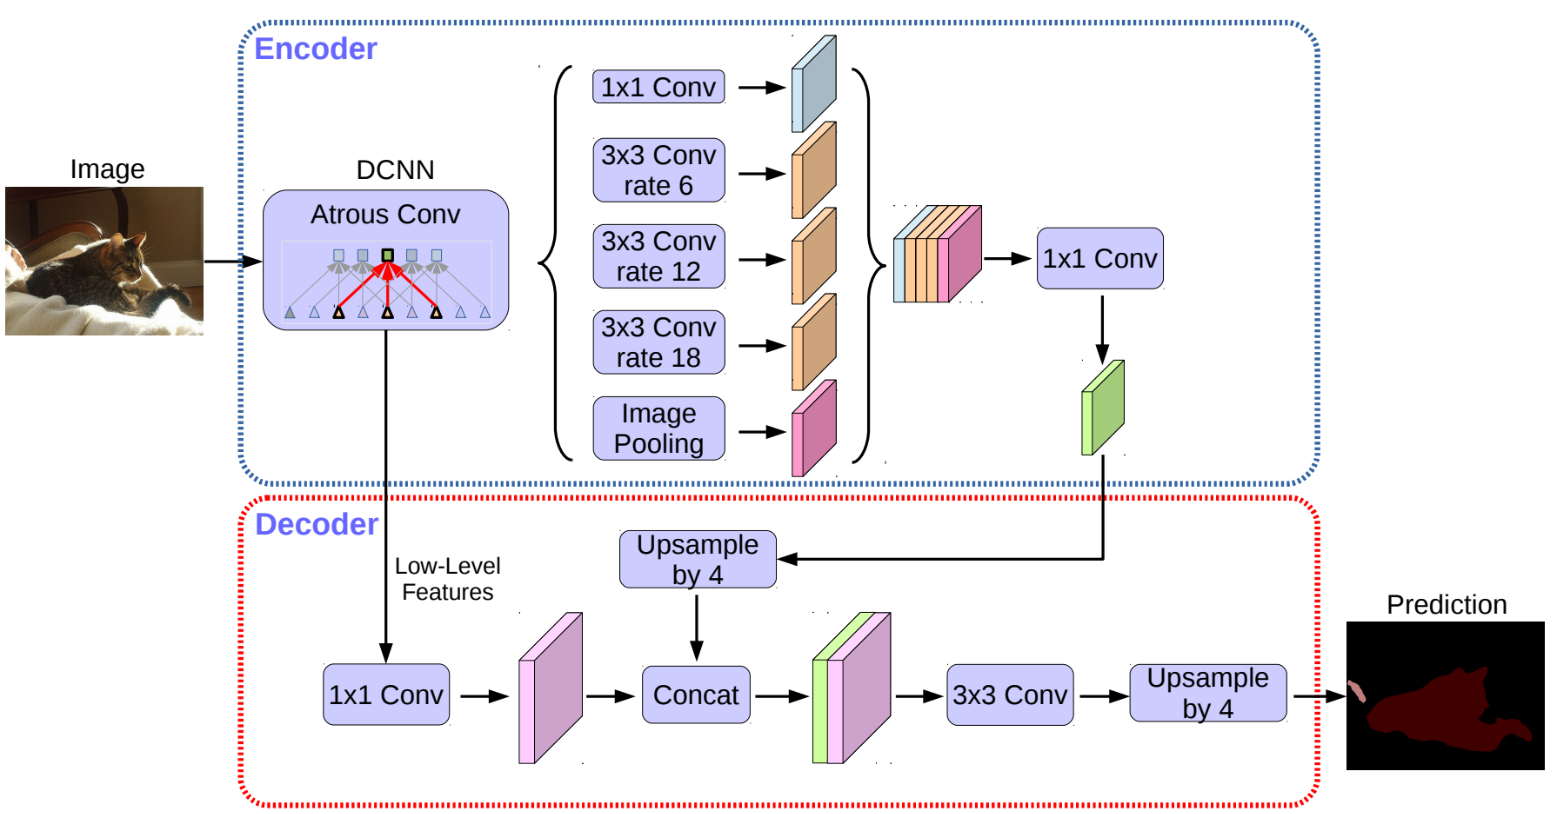

In this model, the **Convolutional Layer**, **Batch Normalization** and **ReLU Layers** are continuously used. So instead of coding them **again and again**, let's encode them into a **single layer**.

In [ ]:
class ConvBlock(Layer):
    
    '''
    As in the Model implementation uses, Conv2D -> BatchNormalization -> ReLU. In the same fashion again and again, that why we have created a Single Layer
    which apply this operation. So ConvBlock = Conv2D -> BatchNormalization -> ReLU. This helps us in implementation.
    '''
    
    def __init__(self, filters:int = 256, kernel_size:int = 3, dilation_rate:int = 1, **kwargs) -> None:
        super(ConvBlock, self).__init__(**kwargs)
        
        # Define Parameters
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        
        # Define the model 
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', strides=1, dilation_rate=dilation_rate, activation=None, use_bias=False),
            BatchNormalization(),
            ReLU()
        ])
    
    def call(self, X):
        # Apply the layers
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate
        }

One of the **main prposal of DeepLabV3+** was the **Astrous Spatial Pyramid Pooling Layer**. Let's define this layer,

In [ ]:
def AtrousSpatialPyramidPooling(X):
    
    # Shape
    _, H, W, C = X.shape
    
    # Image Pooling 
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-ImagePool-AP")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[1]), name="ASPP-ImagePool-US")(image_pool)
    
    # Astrous Layers
    conv_1  = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-Conv1")(X)
    conv_6  = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-Conv6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-Conv12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-Conv18")(X)
    
    # Combine All
    combined = Concatenate(name="ASPP-Concatenate")([image_pool, conv_1, conv_6, conv_12, conv_18])
    output = ConvBlock(kernel_size=1, name="ASPP-Out")(combined)
    
    return output

We have the **Sub-Layers** ready. It's time to combine them all and make the **DeepLabV3+ Encoder-Decoder model**.

In [ ]:
# Model Specifications
IMAGE_SIZE = 256
MODEL_NAME = "DeepLab-FloodArea"

# Input Layer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")

# Backbone
backbone = ResNet50(input_tensor=inputs, weights='imagenet', include_top=False)

# High Level Features
DCNN = backbone.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(
    IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]
), name="ASPP-UpSample-Out")(ASPP)

# Low Level Features
LLF = backbone.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combine
concat = Concatenate(axis=-1, name="Concat-LLF-HLF")([LLF, ASPP])
y = ConvBlock(name="TopConvBlock1")(concat)
y = ConvBlock(name="TopConvBlock2")(y)
y = UpSampling2D(size=(
    IMAGE_SIZE//y.shape[1], IMAGE_SIZE//y.shape[2]
), name="Feature-UpSample")(y)

# Output Layer
output = Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid', use_bias=False, name="OutputLayer")(y)

# Model
DeepLabV3 = Model(inputs, output, name=MODEL_NAME)

Let's have a look at the model architecture,

In [ ]:
DeepLabV3.summary()

**Visualising the model architecture** will give us a **better representation* of the **model architecture**.

# **DeepLabV3+ Visualization**

In [ ]:
plot_model(DeepLabV3, MODEL_NAME+".png", dpi=96, show_shapes=True)

This is our model architecture. Let's work on the **Training the Model**.

# **Model Callback**

It will be a **great idea** if we can **visualize the model's predictions** during the **training time**. In order to do so, here we create a **Callback** to plot the **model's predictions**.

In [ ]:
def show_model_preds(images, masks, model, SIZE:tuple = (15,8)) -> None:
    # Collect Image and Mask
    id = np.random.randint(len(test_images))
    image, mask = images[id], masks[id]
    
    # Make Prediction 
    pred_mask = model.predict(tf.expand_dims(image, axis=0))
            
    # Grad CAM
    cam = GradCAM()
    capture = cam.explain(
        validation_data=(tf.expand_dims(image, axis=0).numpy(), mask),
        model=model,
        class_index=1,
        layer_name="TopConvBlock2"
    )
            
    # Plot Size
    plt.figure(figsize=SIZE)
    
    # Plot Image
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    
    # Plot Original Mask
    plt.subplot(1,4,2)
    plt.title("Expected Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
            
    # Plot Predicted Mask
    plt.subplot(1,4,3)
    plt.imshow(tf.squeeze(pred_mask), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
            
    # Grad CAM
    plt.subplot(1,4,4)
    plt.title("Grad CAM Visualization")
    plt.imshow(tf.squeeze(capture))
    plt.axis('off')
            
    # Show the Final Plot
    plt.show()

In [ ]:
class ShowProgress(Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1)%10==0:
            show_model_preds(test_images, test_masks, self.model)

In [ ]:
# Compile
DeepLabV3.compile(
    loss='binary_crossentropy',
    optimizer="adam"
)

# Callbacks
callbacks = [
    ModelCheckpoint(MODEL_NAME+".h5", save_best_only=True),
    ShowProgress()
]

# Train
history = DeepLabV3.fit(
    train_images, train_masks,
    validation_data=(test_images, test_masks),
    epochs=100,
    callbacks=callbacks,
    batch_size=8,
)

***Model Training :***

1. As you can see that during the training the **model performance increases** and it gets **better and better** in predicting the **binary label masks**. 
2. The **Grad CAM** shows that the **model was able to concentrate** on the **water bodies only**.
3. You might also notice that the **predicted Label Maps** are a **little blurry** this is because the **model cannot predict** a **sharp boundary** neither it is needed.
4. The **loss made a perfect curve**, it continuously decreases forming a **perfect learning curve**, although the **curve is not perfect**.
5. During the **72th Epoch** the **training diverges** but this is something which I have seem a lot of time with **DeepLabV3+**, and suprisingly the model **starts performing better after this divergence**.

# **Learning Curve**

In [ ]:
pd.DataFrame(history.history).plot(figsize=(15,5))
plt.ylim([0.0,1.0])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

The difference in the **Training and Validation Loss** is **not high**, this is a **good sign**.

# **Model Predictions**

Let's have a closer look at the model predictions,

In [ ]:
for i in range(20):
    show_model_preds(test_images, test_masks, model=DeepLabV3, SIZE=(25,8))

The **model predictions** are **not perfect** but they are **pretty close to be perfect**, the **model predictions** are **convincing** and somtimes it seems like **model is right and the true label is wrong**. The **predicted label maps** lack the clarity or we can say that they **lack the sharpness**, but this was **expected by the model**. If you closely pay attention to the 

That's all from my side, please let me know your suggestions in the comment box.

---
**DeepNets**